# Introduction

La pratique de l'aviron en milieu naturel, comme sur les fleuves et rivières, dépend fortement des conditions hydrologiques telles que le débit et la hauteur d'eau. Ces paramètres jouent un rôle crucial dans la sécurité des rameurs, la qualité de l'expérience sportive, et l'organisation des entraînements et des compétitions. Toutefois, les variations du débit et de la hauteur d'eau, souvent influencées par les conditions météorologiques (pluies, sécheresses), rendent leur prévision essentielle pour les clubs d'aviron et leurs pratiquants. Ce projet, centré sur la Seine, vise donc à développer un modèle de prédiction fondé sur des données hydrométriques et météorologiques, permettant d'anticiper les conditions optimales pour la pratique de l'aviron ou à l'inverse de détecter ses potentiels dangers. En combinant l'analyse de données historiques, allant du 01/01/23 à aujourd'hui, avec des approches de modélisation, ce travail a pour objectif de fournir un outil fiable et pratique pour faciliter la planification et garantir la sécurité de la pratique sportive.

Ce projet comprend 3 grandes parties : 
- Dans la première partie, nous importons les bases de données utiles
- Dans la deuxième partie, nous étudions et analysons les données recueillies pour préparer le modèle prédictif
- Dans la troisième partie, nous modélisons le problème pour tenter d'y apporter une réponse satisfiasante

In [2]:
# !pip install cartopy
# !pip install geopy

In [59]:
import os
import requests

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import glob
import numpy as np

from datetime import datetime, timedelta
from scipy.spatial import distance

In [4]:
os.chdir("/home/onyxia/work/Projet-de-Python-Leroux-Gisserot") # pour l'emplacement
os.environ["PROJ_LIB"] = "/opt/conda/share/proj" # pour les projections sur carte

# Data loading

Dans cette partie, nous importons de data.gouv.fr :
- des bases de données météo horaire pour chaque département
- une base de données concernant la hauteur d'eau et le débit des cours d'eau
- une base de données permettant de tracer ces cours d'eau sur une carte
- une base de données permettant de localiser les clubs d'aviron

In [5]:
from utils.data_loading import (
    read_csv_from_url, 
    load_department_data,
    load_and_save_all_department_data,
    load_data_from_disk,
    cleaning_and_organizing,
    get_coordinates,
    import_geojson_from_url,
    find_nearest_station,
    add_station_info_to_clubs,
)

---

Téléchargement des bases de données météo horaire, puis concaténation et nettoyage

In [6]:
'''
load_and_save_all_department_data(
    department_ids=["10", "27", "76", "77", "78", "91", "92", "95"], # départements par lesquels passe la Seine
    save_dir="/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-weather-23-24"
)
'''

'\nload_and_save_all_department_data(\n    department_ids=["10", "27", "76", "77", "78", "91", "92", "95"], # départements par lesquels passe la Seine\n    save_dir="/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-weather-23-24"\n)\n'

In [7]:
meteo_horaire = load_data_from_disk(data_dir="/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-weather-23-24")

Loading and concatenating data from disk: 100%|██████████| 8/8 [00:00<00:00, 10.36it/s]


In [8]:
meteo_horaire = cleaning_and_organizing(
                                df=meteo_horaire,
                                columns=["DEPARTMENT_ID", "NOM_USUEL", "AAAAMMJJHH"],
                                date="AAAAMMJJHH"
                            )

Le dataframe meteo_horaire contient les colonnes suivantes :
- DEPARTMENT_ID : le numéro du département où se trouve la station météo
- NUM_POSTE : l'identifiant de la station météo
- NOM_USUEL : le nom de la commune où se trouve la station météo
- LAT et LON : les coordonnées de la station météo
- AAAAMMJJHH : la date exacte, à l'heure près, de la collecte d'information
- RR1 : les précipitations tombées en une heure (en mm)
- T : la température moyenne enregistrée pendant cette heure

On crée ensuite 2 dataframes :
- l'un nous servira pour entraîner le modèle (données receuillies entre le 1er janvier 2023 et le 30 novembre 2024)
- l'autre nous servira à faire des prédictions effectives (données receuillies sur les 30 derniers jours)

In [9]:
date_limite = pd.to_datetime("2024-12-01 00:00:00")
meteo_horaire_train = meteo_horaire[meteo_horaire['AAAAMMJJHH'] < date_limite]

In [10]:
date_ajd = pd.to_datetime(datetime.now())
date_debut = date_ajd - timedelta(days=30)
meteo_horaire_pred = meteo_horaire[(meteo_horaire['AAAAMMJJHH'] > date_debut) & (meteo_horaire['AAAAMMJJHH'] <= date_ajd)]

---

Création du dataset clubs d'aviron et récupération de leurs coordonnées GPS

In [35]:
clubs_aviron = pd.read_csv('/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/adresses_clubs.csv', sep=';', header=0)

In [36]:
clubs_aviron[['LAT', 'LON']] = clubs_aviron['Adresse'].apply(get_coordinates)

---

Création du dataset stations hydrométriques

In [37]:
liste_stations_hydro = pd.read_csv('/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/liste-stations.csv', sep=';', header=0)
liste_stations_hydro = liste_stations_hydro.rename(columns={'cdentite': 'NUM_POSTE', 'lbstationhydro': 'NOM_USUEL', 'longitude': 'LON', 'latitude': 'LAT'})
liste_stations_hydro = liste_stations_hydro[~liste_stations_hydro["dtfermeture"].notna()] #Filtration des stations hydrométriques encore en activité
liste_stations_hydro = liste_stations_hydro.drop(['typestation', 'dtmiseservice', 'dtfermeture'], axis=1)

---

Ajout des stations météo et hydro les plus proches de chaque club d'aviron

In [38]:
stations_meteo_clubs = add_station_info_to_clubs(clubs_aviron, meteo_horaire, filter_keyword=None)
stations_meteo_clubs = stations_meteo_clubs.rename(columns={'NUM_POSTE': 'NUM_NWS', 'NOM_USUEL': 'NWS'}) # NWS = Nearest Weather Station

In [39]:
stations_hydro_clubs = add_station_info_to_clubs(clubs_aviron, liste_stations_hydro, filter_keyword='Seine')
stations_hydro_clubs = stations_hydro_clubs.rename(columns={'NUM_POSTE': 'NUM_NHS', 'NOM_USUEL': 'NHS'}) # NHS = Nearest Hydro Station

In [40]:
clubs_hydro_meteo = pd.merge(stations_meteo_clubs, stations_hydro_clubs, on=["Club", "Adresse", "LAT", "LON"], how="inner")
clubs_hydro_meteo

,Club,Adresse,LAT,LON,NUM_NWS,NWS,NUM_NHS,NHS
0,Aviron Caudebec Vallée de Seine,9 route de Villequier 76490 Rives-en-Seine,49.523301,0.711545,76473001,NOTRE-DAME DE BLIQUETUIT,H512011001,La Seine à Caudebec-en-Caux
1,Cercle nautique de Canteleu-Croisset,46 Quai Gustave Flaubert 76380 Canteleu,49.432259,1.027617,76540009,ROUEN - JARDIN,H503011001,La Seine à Rouen
2,Club Nautique Et Athletique De Rouen,20 Rue de l'Industrie 76100 Rouen,49.435429,1.097776,76540009,ROUEN - JARDIN,H503011001,La Seine à Rouen
3,Club nautique de Belbeuf,8 Rte de Paris 76240 Belbeuf,49.368952,1.128761,76116001,ROUEN-BOOS,H501012001,La Seine à Oissel
4,Aviron Club Andelys-Tosny,Chemin de la Haguette 27700 Les Trois Lacs,49.229422,1.387091,27016001,LES ANDELYS,H320000104,La Seine à Vernon - Station débitmétrique (>2006)
5,Emulation Nautique de Vernon,Impasse de la Chaussée 27200 Vernon,49.098234,1.488845,27016001,LES ANDELYS,H320000104,La Seine à Vernon - Station débitmétrique (>2006)
6,Association sportive Mantaise,"Boulevard Sully, 78200 Mantes-la-Jolie",49.001702,1.677995,78354001,MAGNANVILLE,H308000101,La Seine à Limay [Mantes]
7,Aviron Meulan-les-Mureaux Hardricourt,15 Rue de Lorraine 78200 Mantes-la-Jolie,48.987197,1.713332,78354001,MAGNANVILLE,H308000101,La Seine à Limay [Mantes]
8,Aviron Club de Villennes-Poissy,Chemin des Pêcheurs 78670 Villennes-sur-Seine,48.931335,2.007350,78481001,LE PECQ,H300000201,La Seine à Poissy
9,Rowing Club de Port-Marly,12 Rue de Paris 78560 Le Port-Marly,48.879645,2.111762,78481001,LE PECQ,F712000102,La Seine à Chatou - Barrage (aval)


Les stations hydrométriques ne proposant pas une API pour avoir accès à leurs archives, il est nécessaire de télécharger leurs datasets de manière indépendante.

In [83]:
liste_stations_a_récupérer = []
for element in stations_hydro_clubs['NUM_NHS']:
    if element not in liste_stations_a_récupérer :
        liste_stations_a_récupérer.append(element)

# Voila les stations dont on doit télécharger l'historique des données hydro à la main
print("Les stations dont il faut récupérer les données dans les archives hydrométriques sont : " + ", ".join(liste_stations_a_récupérer))

Les stations dont il faut récupérer les données dans les archives hydrométriques sont : H512011001, H503011001, H501012001, H320000104, H308000101, H300000201, F712000102, F704000102, F704000101, F490000104, F449000601, F447000101, F400000301, H170001001, H080001101


In [41]:
# Cleaning des datasets et insertion dans un dictionnaire pour y avoir accès à tous en même temps

# Chemin où se trouvent les fichiers de débit des stations hydrométriques
chemin_fichiers = "/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-flow-rate-23-24/*.csv"

# Chargement dans un dictionnaire
fichiers = glob.glob(chemin_fichiers)
dictionnaire_df_stations_hydro = {}

for fichier in fichiers :
    # Extraire le NUM_POSTE du nom du fichier
    NUM_POSTE = fichier.split("/")[-1].split(".")[0]
    df = pd.read_csv(fichier)

    #Création d'une colonne date time pour uniformiser avec les donénes météo ensuite)
    df['Datetime'] = pd.to_datetime(df['Date (TU)'].str.replace('Z', ''), format='%Y-%m-%dT%H:%M:%S.%f')
    # Supprimer les colonnes inutiles
    df = df.drop(columns=["Date (TU)", "Statut", "Qualification", "Méthode", "Continuité"], errors="ignore")
    df = df[['Datetime', 'Valeur (en m³/s)']]

    # Convertir la colonne "Valeur (en m³/s)" en entier
    df["Valeur (en m³/s)"] = pd.to_numeric(df["Valeur (en m³/s)"].astype(str).str.replace(",", "").str.replace('"', ""), errors="coerce").fillna(0).astype(int)
    

    dictionnaire_df_stations_hydro[NUM_POSTE] = df

# Vérification des clés  (à savoir les NUM_POSTE)
print("Numéros de postes hydrométriques disponibles :", dictionnaire_df_stations_hydro.keys())



for nom, df in dictionnaire_df_stations_hydro.items():
    print(f"Les 5 premières lignes de {nom}:")
    print(df.head())  # Affiche les 5 premières lignes
    print()  # Ligne vide pour la lisibilité


#On a finalement un dictionnaire avec tous les dataframes des bases hydro à l'interieur, avec uniquement le débit heure par heure à chaque station.

Numéros de postes hydrométriques disponibles : dict_keys(['F490000104', 'H320000104', 'H512011001', 'F447000101', 'H503011001', 'H080001101', 'F704000102', 'H300000201', 'F704000101', 'F449000601', 'H308000101', 'F400000301', 'H170001001', 'F712000102', 'H501012001'])
Les 5 premières lignes de F490000104:
             Datetime  Valeur (en m³/s)
0 2023-01-01 00:00:00               237
1 2023-01-01 01:00:00               238
2 2023-01-01 02:00:00               241
3 2023-01-01 03:00:00               233
4 2023-01-01 04:00:00               235

Les 5 premières lignes de H320000104:
             Datetime  Valeur (en m³/s)
0 2023-01-01 00:00:00               503
1 2023-01-01 01:00:00               508
2 2023-01-01 02:00:00               515
3 2023-01-01 03:00:00               521
4 2023-01-01 04:00:00               522

Les 5 premières lignes de H512011001:
             Datetime  Valeur (en m³/s)
0 2023-01-01 00:00:00               748
1 2023-01-01 01:00:00               748
2 2023-01-01 02

Création du dictionnaire contenant les df des données météo : 

In [42]:
# 1. Charger tous les fichiers CSV d'un dossier spécifique
chemin_fichiers = '/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-weather-23-24/*.csv'
files = glob.glob(chemin_fichiers)

# 2. Créer un dictionnaire pour stocker les DataFrames par station
dictionnaire_df_stations_meteo = {}

# Parcourir chaque fichier CSV
for file in files:
    # Lire chaque fichier CSV
    df = pd.read_csv(file)
        
    # Convertir la colonne 'AAAAMMJJHH' en datetime
    df['Datetime'] = pd.to_datetime(df['AAAAMMJJHH'], format='%Y%m%d%H')
    
    # Sélectionner les colonnes nécessaires
    df_filtered = df[['Datetime', 'NUM_POSTE', 'T', 'RR1']]
    
    # Définir 'Datetime' comme index
    df_filtered.set_index('Datetime', inplace=True)
    
    # Parcourir chaque station (NUM_POSTE)
    for station_id in df_filtered['NUM_POSTE'].unique():
        # Filtrer les données pour cette station
        df_station = df_filtered[df_filtered['NUM_POSTE'] == station_id].drop(columns='NUM_POSTE')
    
        # Ajouter ou mettre à jour le DataFrame de la station dans le dictionnaire
        if station_id not in dictionnaire_df_stations_meteo:
            dictionnaire_df_stations_meteo[station_id] = df_station
        else:
            dictionnaire_df_stations_meteo[station_id] = pd.concat([dictionnaire_df_stations_meteo[station_id], df_station])
        
# Vérification du résultat
for station_id, station_df in dictionnaire_df_stations_meteo.items():
    print(f"DataFrame pour la station {station_id}:")
    print(station_df)
    print("\n")

print("NUM_POSTE disponibles dans le dictionnaire :", dictionnaire_df_stations_meteo.keys())

DataFrame pour la station 77054001:
                        T  RR1
Datetime                      
2023-01-01 00:00:00  14.2  0.0
2023-01-01 01:00:00  13.7  0.0
2023-01-01 02:00:00  13.5  0.0
2023-01-01 03:00:00  13.3  0.0
2023-01-01 04:00:00  12.8  0.0
...                   ...  ...
2024-12-20 23:00:00   6.3  0.0
2024-12-21 00:00:00   6.5  0.0
2024-12-21 01:00:00   6.6  0.2
2024-12-21 02:00:00   7.2  0.0
2024-12-21 03:00:00   7.5  0.2

[17272 rows x 2 columns]


DataFrame pour la station 77084001:
                        T  RR1
Datetime                      
2023-01-01 00:00:00  13.9  0.0
2023-01-01 01:00:00  14.1  0.0
2023-01-01 02:00:00  14.1  0.0
2023-01-01 03:00:00  13.7  0.0
2023-01-01 04:00:00  13.4  0.0
...                   ...  ...
2024-12-20 23:00:00   6.5  0.6
2024-12-21 00:00:00   6.5  0.2
2024-12-21 01:00:00   6.8  0.0
2024-12-21 02:00:00   7.0  0.4
2024-12-21 03:00:00   7.6  0.0

[17165 rows x 2 columns]


DataFrame pour la station 77113002:
                        T  RR1

In [43]:
debit_horaire = load_data_from_disk(data_dir="/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-flow-rate-23-24")

Loading and concatenating data from disk: 100%|██████████| 15/15 [00:00<00:00, 95.27it/s]


In [44]:
station_ids = clubs_hydro_meteo['NUM_NHS'].drop_duplicates().tolist()

Je n'arrive pa a debugger

In [46]:
for station in station_ids :    
    file_name = f"/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-flow-rate-23-24/{station}.csv"
    df = pd.read_csv(file_name)
    df['NUM_POSTE'] = f"{station}"
    df['NOM_USUEL'] = clubs_hydro_meteo.loc[clubs_hydro_meteo['Club'] == nom_club, 'NWS'].iloc[0]
    
    # last_col = df.columns[-1]  # Identifie la dernière colonne
    # new_order = [last_col] + list(df.columns[:-1])  # Réorganise les colonnes
    # df = df[new_order]
    
    df.to_csv(file_name, index=False)

NameError: name 'nom_club' is not defined

---

Importation de la base de données fluviales

In [ ]:
'''
rivers = import_geojson_from_url(
                geojson_url="https://www.data.gouv.fr/fr/datasets/r/f354a037-4a4e-4e7e-804b-01278ab228c5",
                geojson_file="/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/rivers.geojson"
            )
'''

# **Data analysis**

In [ ]:
from utils.data_analysis import (
    carte_figures,
    trace_graphique,
    trace_graphique_multiple,
)

**1. Représentation graphique des fleuves, des stations météo et hydro, et des clubs d'aviron**

In [ ]:
coord_ws = pd.merge(clubs_hydro_meteo, meteo_horaire, left_on='NUM_NWS', right_on='NUM_POSTE', how="inner")
coord_ws = coord_ws[["NUM_NWS", "NWS", "LAT_y", "LON_y"]].drop_duplicates()
coord_ws = coord_ws.rename(columns={'LAT_y': 'LAT', 'LON_y': 'LON'})

In [ ]:
coord_hs = pd.merge(clubs_hydro_meteo, liste_stations_hydro, left_on='NUM_NHS', right_on='NUM_POSTE', how="inner")
coord_hs = coord_hs[["NUM_NHS", "NHS", "LAT_y", "LON_y"]].drop_duplicates()
coord_hs = coord_hs.rename(columns={'LAT_y': 'LAT', 'LON_y': 'LON'})

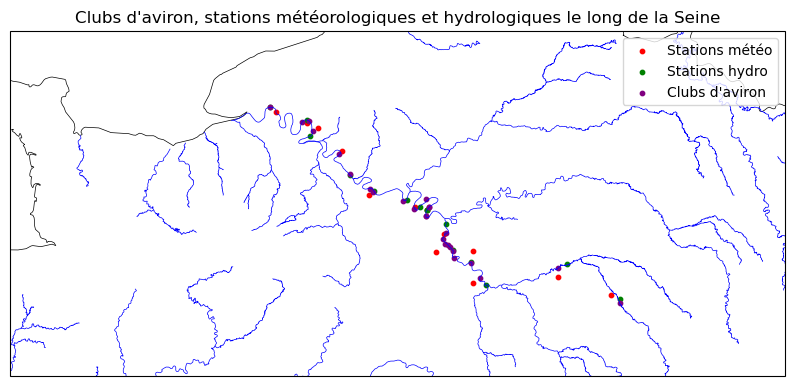

In [ ]:
carte_figures(rivers, coord_ws, coord_hs, clubs_aviron)

On choisit à présent un club d'aviron, et indirectement, les stations météorologique et hydrologique les plus proches. Le reste de la partie a pour but de tracer différents graphiques (les précipitations, la température ou encore le débit en fonction du temps) pour tenter de remarquer des tendances ou des corrélations entres les variables.

In [ ]:
nom_club = 'Emulation Nautique de Vernon'
nws = clubs_hydro_meteo.loc[clubs_hydro_meteo['Club'] == nom_club, 'NWS'].iloc[0]
nhs = clubs_hydro_meteo.loc[clubs_hydro_meteo['Club'] == nom_club, 'NHS'].iloc[0]
print(f'Les stations météo et hydro les plus proches de {nom_club} sont {nws} et {nhs}')

Les stations météo et hydro les plus proches de Emulation Nautique de Vernon sont LES ANDELYS et La Seine à Vernon - Station débitmétrique (>2006)


---

**2. Graphe des précipitations en fonction du temps**

2. a. <u>Heure par heure</u>

In [ ]:
meteo_nws = meteo_horaire[meteo_horaire["NOM_USUEL"] == nws].copy()
meteo_nws = meteo_nws.dropna(subset=['RR1', 'T'])

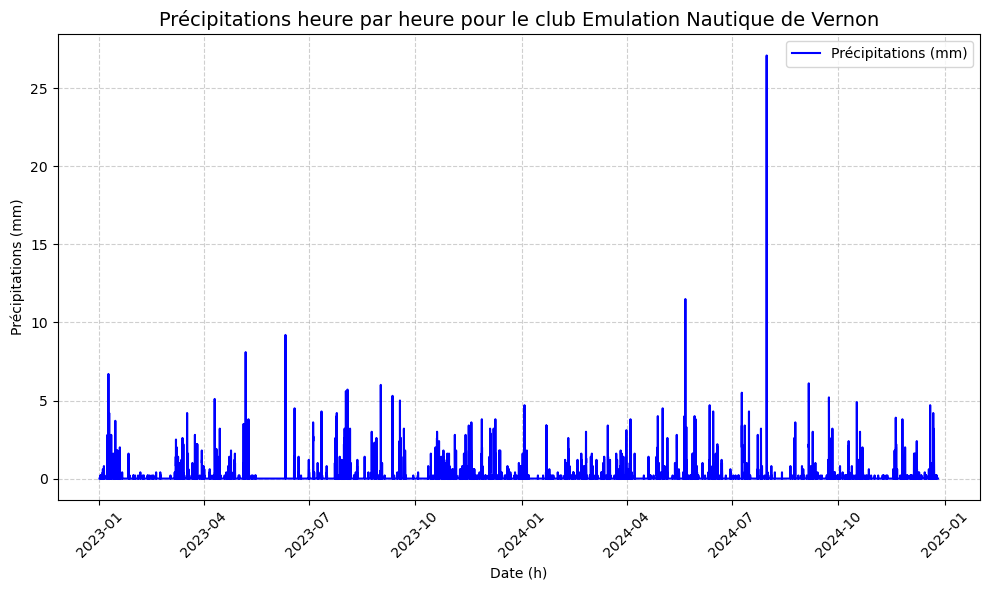

In [ ]:
trace_graphique(
    x=meteo_nws["AAAAMMJJHH"],
    y=meteo_nws["RR1"],
    titre=f"Précipitations heure par heure pour le club {nom_club}",
    xlabel="Date (h)",
    ylabel="Précipitations (mm)",
)

Ce graphique détaille les précipitations enregistrées **heure par heure**. Il met en évidence la nature très variable des précipitations, avec de nombreux pics irréguliers.  
- Les pics isolés témoignent de périodes courtes mais **intenses de précipitation**.  
- Entre ces pics, les précipitations sont souvent nulles ou très faibles.  

Cette granularité **horaire**, utile pour analyser la variabilité des précipitations à court terme, rend difficile la lecture des **tendances globales** à cause de l'apparente saturation de l'information.

Pour un modèle de prévision du débit, ces données brutes heure par heure peuvent donc être **trop détaillées** pour être directement exploitées. En effet, les débits d'un cours d'eau dépendent davantage de cumuls sur des périodes plus longues (journées ou semaines) que d'événements ponctuels. Il faut de toute façon étudier l'impact que peut avoir une grosse averse, come observée vers août 2024, sur le débit de la Seine.

2. b. <u>Par semaine</u>

In [ ]:
# On crée un dataframe où les précipitations sont sommées par semaine
meteo_nws['hebdo'] = meteo_nws['AAAAMMJJHH'].dt.to_period('W')
precipit_hebdo = meteo_nws.groupby('hebdo', as_index=False)['RR1'].sum()
precipit_hebdo['hebdo'] = precipit_hebdo['hebdo'].dt.to_timestamp(how='start')

# Puis on fait une moyenne glissante sur 3 semaines pour lisser la courbe
precipit_hebdo['moy_gliss'] = precipit_hebdo['RR1'].rolling(window=3, min_periods=1, center=True).mean()

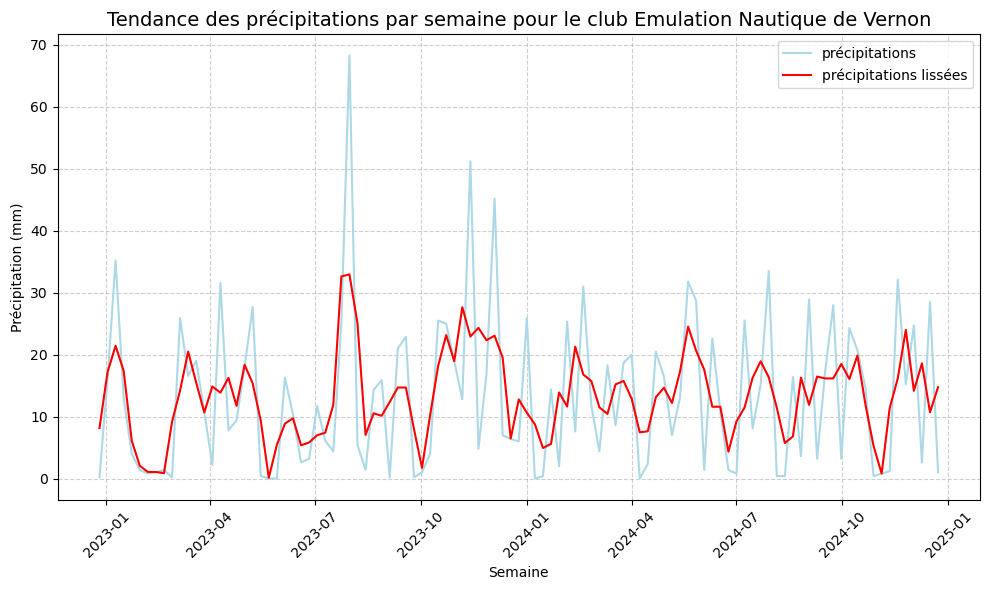

In [ ]:
# Préparation des données pour la fonction
y_dico1 = {
    "précipitations": {"y": precipit_hebdo["RR1"], "color": "lightblue", "linestyle": "-"},
    "précipitations lissées": {"y": precipit_hebdo["moy_gliss"], "color": "red", "linestyle": "-"}
}

# Appel de la fonction
trace_graphique_multiple(
    x=precipit_hebdo["hebdo"],
    y_mult=y_dico1,
    titre=f'Tendance des précipitations par semaine pour le club {nom_club}',
    xlabel="Semaine",
    ylabel="Précipitation (mm)",
)

Ce graphique agrège les précipitations à une échelle **hebdomadaire**, ce qui permet de mieux identifier les **tendances globales** dans les précipitations :  
- En bleu clair : la somme hebdomadaire des précipitations montre les fluctuations globales des précipitations au fil du temps.  
- En rouge : la moyenne glissante sur 3 semaines lisse les variations hebdomadaires, révélant les tendances de fond sans être perturbée par des oscillations trop rapides.

Ce lissage est particulièrement utile pour **détecter les périodes humides ou sèches prolongées**, qui influencent directement le débit des cours d'eau. On observe plusieurs pics significatifs sur l'année 2023 (notamment au printemps et en automne), ce qui est cohérent avec les périodes de précipitations accrues.  

Les **sommations hebdomadaires** permettent de mieux **relier les précipitations aux variations de débit**, car elles intègrent une échelle temporelle plus pertinente pour l'évolution du niveau d'eau. La **moyenne glissante** aide à anticiper les périodes où les cours d'eau risquent d'atteindre des niveaux élevés, en réponse à des cumuls prolongés.

---

Pour **prédire le débit d'un cours d'eau**, il serait pertinent d'utiliser les données hebdomadaires comme **variable explicative principale**, en intégrant les tendances de fond issues de la moyenne glissante pour améliorer les prédictions.

---

**3. Graphe des températures en fonction du temps**

3. a. <u>Heure par heure</u>

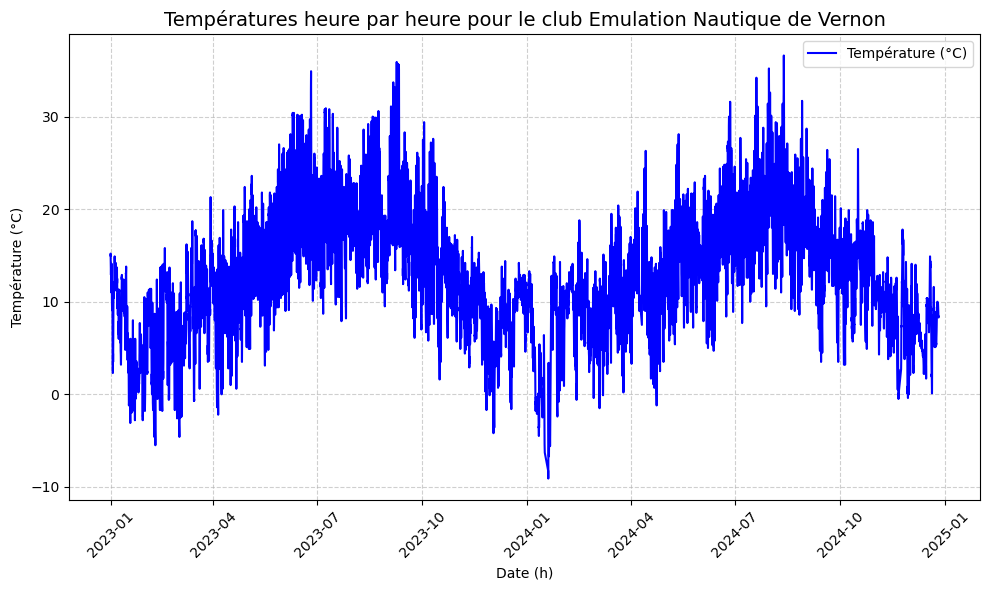

In [ ]:
trace_graphique(
    x=meteo_nws["AAAAMMJJHH"],
    y=meteo_nws["T"],
    titre=f"Températures heure par heure pour le club {nom_club}",
    xlabel="Date (h)",
    ylabel="Température (°C)",
)

Ce graphique montre l'évolution de la température en fonction du temps à une résolution horaire. Il met à la fois en évidence les tendances globales de température en fonction des saisons (20-25°C vers juillet-août aussi bien en 2023 qu'en 2024, autour de 5°C en janvier-février) et la variabilité journalière des températures.

**Saisonnalité temporelle** : ce type de comportement est crucial pour la prédiction des débits, car les températures influencent l'évaporation, la fonte des neiges, et potentiellement le débit des cours d'eau.

**Variabilité horaire** : les fluctuations à court terme de la température sont visibles sous forme de variations rapides autour de la tendance globale. Ces variations peuvent être liées à des événements météorologiques locaux (comme des fronts froids ou chauds) qui affectent aussi les précipitations et, par extension, les débits des rivières.

**Implication pour la prédiction du débit** : les températures, combinées aux précipitations, influencent directement le débit par la fonte des neiges, l'infiltration dans les sols, et l'évaporation. Ces variations saisonnières et horaires de température doivent donc être intégrées comme une variable explicative dans le modèle de prédiction.

3. b. <u>Par semaine</u>

In [ ]:
# On reproduit la même méthode que pour les précipitations
temp_hebdo = meteo_nws.groupby('hebdo', as_index=False)['T'].mean()
temp_hebdo['hebdo'] = temp_hebdo['hebdo'].dt.to_timestamp(how='start')
temp_hebdo['moy_gliss'] = temp_hebdo['T'].rolling(window=3, min_periods=1, center=True).mean()

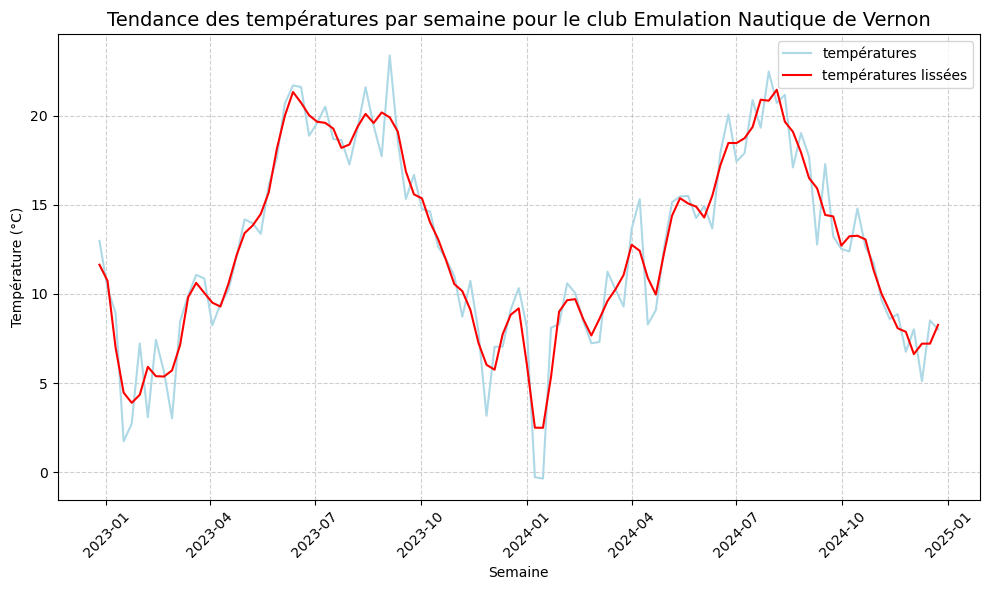

In [ ]:
# Préparation des données pour la fonction
y_dico2 = {
    "températures": {"y": temp_hebdo["T"], "color": "lightblue", "linestyle": "-"},
    "températures lissées": {"y": temp_hebdo["moy_gliss"], "color": "red", "linestyle": "-"}
}

# Appel de la fonction
trace_graphique_multiple(
    x=temp_hebdo["hebdo"],
    y_mult=y_dico2,
    titre=f'Tendance des températures par semaine pour le club {nom_club}',
    xlabel="Semaine",
    ylabel="Température (°C)",
)

Ici, on se restreint à la compréhension des tendances globales de températures. Cette restriction permet pas de voir de corrélation directe avec les précipitations. Les températures et les précipitations jouent donc probablement leur rôle dans la prédiction du débit des cours d'eau de manière indépendante.

Mais on peut d'ores-et-déjà émettre quelques hypothèses : 
- plus les précipitations sont importantes et plus elles durent longtemps, plus le débit sera élevé, ceteris paribus
- plus la température est élevée et plus la période de chaleur est longue, plus le débit sera faible, ceteris paribus
- plus la température est élevée, plus les précipitations ont un impact positif sur le débit (par ruissellement)

**4. Graphe du débit en fonction du temps**

# **Data modeling**

Formalisation des requêtes de recherche dans les dictionnaires précédemment crées : 
Il suffit d'entrer le nom du club sur lequel on souhaite obtenir l'ensemble des données

In [48]:
nom_club = 'Emulation Nautique de Vernon'

def get_station_data_by_club(club_name, df_adresses_clubs, dictionnaire_df_stations_hydro):
    """
    Récupère les données de débit de la station hydrométrique associée à un club d'aviron.

    Args:
        club_name (str): Le nom du club d'aviron.
        df_adresses_clubs (DataFrame): DataFrame contenant les clubs et leurs stations associées.
        dictionnaire_df_stations_hydro (dict): Dictionnaire contenant les DataFrames des données de débit.

    Returns:
        DataFrame or None: Les données de débit de la station associée au club ou None si non trouvé.
    """
 # Trouver l'identifiant de la station associée au club
    station_id = clubs_hydro_meteo.loc[clubs_hydro_meteo['Club'] == club_name, 'NUM_NHS'].values
    if len(station_id) == 0:
        print(f"Aucune station associée au club : {club_name}")
        return None

    station_id = station_id[0]  # Extraire l'identifiant unique
    
    # Récupérer les données de la station
    if station_id in dictionnaire_df_stations_hydro:
        return dictionnaire_df_stations_hydro[station_id]
    else:
        print(f"Aucune donnée de débit trouvée pour la station : {station_id}")
        return None


print(get_station_data_by_club ( nom_club, clubs_hydro_meteo, dictionnaire_df_stations_hydro))
df_debit=get_station_data_by_club ( nom_club, clubs_hydro_meteo, dictionnaire_df_stations_hydro)


def get_meteo_data_by_club(club_name, df_adresses_clubs, dictionnaire_df_stations_meteo ):

 # Trouver l'identifiant de la station associée au club
    station_id = clubs_hydro_meteo.loc[clubs_hydro_meteo['Club'] == club_name, 'NUM_NWS'].values
    if len(station_id) == 0:
        print(f"Aucune station associée au club : {club_name}")
        return None

    station_id = station_id[0]  # Extraire l'identifiant unique
    
    # Récupérer les données de la station
    if station_id in dictionnaire_df_stations_meteo:
        return dictionnaire_df_stations_meteo[station_id]
    else:
        print(f"Aucune donnée de débit trouvée pour la station : {station_id}")
        return None

print(get_meteo_data_by_club ( nom_club , clubs_hydro_meteo, dictionnaire_df_stations_meteo))

df_meteo=get_meteo_data_by_club( nom_club, clubs_hydro_meteo, dictionnaire_df_stations_meteo)



                 Datetime  Valeur (en m³/s)
0     2023-01-01 00:00:00               503
1     2023-01-01 01:00:00               508
2     2023-01-01 02:00:00               515
3     2023-01-01 03:00:00               521
4     2023-01-01 04:00:00               522
...                   ...               ...
16795 2024-11-30 19:00:00               713
16796 2024-11-30 20:00:00               708
16797 2024-11-30 21:00:00               696
16798 2024-11-30 22:00:00               693
16799 2024-11-30 23:00:00               686

[16800 rows x 2 columns]
                        T  RR1
Datetime                      
2023-01-01 00:00:00  15.0  0.0
2023-01-01 01:00:00  15.2  0.0
2023-01-01 02:00:00  14.9  0.0
2023-01-01 03:00:00  14.4  0.0
2023-01-01 04:00:00  14.1  0.0
...                   ...  ...
2024-12-20 23:00:00   7.7  0.4
2024-12-21 00:00:00   7.8  0.4
2024-12-21 01:00:00   8.1  0.0
2024-12-21 02:00:00   8.4  0.0
2024-12-21 03:00:00   8.2  0.0

[17284 rows x 2 columns]


Et la fusion : 

In [49]:
# Fusionner les DataFrames sur la colonne datetime
df_combined = pd.merge(df_debit, df_meteo, on='Datetime', how='outer', suffixes=('_debit', '_meteo'))

# Trier les données par datetime et réinitialiser l'index
df_combined = df_combined.sort_values(by='Datetime').reset_index(drop=True)

df_combined
df_combined = df_combined.drop_duplicates(subset='Datetime').reset_index(drop=True)
# Afficher les premières lignes du DataFrame combiné
print(df_combined)

                 Datetime  Valeur (en m³/s)     T  RR1
0     2023-01-01 00:00:00             503.0  15.0  0.0
1     2023-01-01 01:00:00             508.0  15.2  0.0
2     2023-01-01 02:00:00             515.0  14.9  0.0
3     2023-01-01 03:00:00             521.0  14.4  0.0
4     2023-01-01 04:00:00             522.0  14.1  0.0
...                   ...               ...   ...  ...
17279 2024-12-20 23:00:00               NaN   7.7  0.4
17280 2024-12-21 00:00:00               NaN   7.8  0.4
17281 2024-12-21 01:00:00               NaN   8.1  0.0
17282 2024-12-21 02:00:00               NaN   8.4  0.0
17283 2024-12-21 03:00:00               NaN   8.2  0.0

[17284 rows x 4 columns]


Il faudra restreindre les datasets de meteo au 30 novembre 2024 (la ou je me suis arreté dans le téléchargement des df débit)

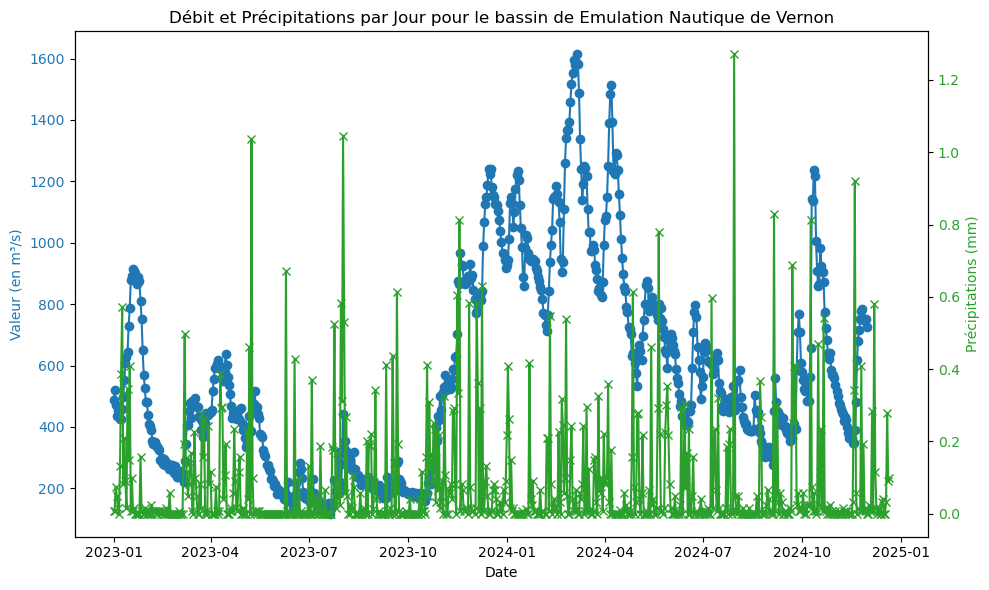

In [ ]:
# Lissage par jour (moyenne quotidienne)
df_daily = df_combined.groupby(df_combined['Datetime'].dt.date).agg({'Valeur (en m³/s)': 'mean', 'RR1': 'mean'}).reset_index()

# Créer le plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot des débits sur le premier axe
ax1.plot(df_daily['Datetime'], df_daily['Valeur (en m³/s)'], color='tab:blue', label='Débit', linestyle='-', marker='o')
ax1.set_xlabel('Date')
ax1.set_ylabel('Débit (en m³/s)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Ajouter un deuxième axe pour les précipitations
ax2 = ax1.twinx()
ax2.plot(df_daily['Datetime'], df_daily['RR1'], color='tab:green', label='Précipitations', linestyle='-', marker='x')
ax2.set_ylabel('Précipitations (mm)', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')


# Titre et affichage
plt.title(f'Débit et Précipitations par Jour pour le bassin de {nom_club}')
fig.tight_layout()
plt.show()

In [84]:
# Initialisation d'une liste pour stocker les DataFrames combinés
dataframes_combined = []

print("Clés disponibles dans dictionnaire_df_stations_hydro :")
print(dictionnaire_df_stations_hydro.keys())

print("Clés disponibles dans dictionnaire_df_stations_meteo :")
print(dictionnaire_df_stations_meteo.keys())

#NUM_POSTE_HYDRO = str(NUM_POSTE_HYDRO)
df_debit = dictionnaire_df_stations_hydro.get(NUM_POSTE_HYDRO)

NUM_POSTE_METEO = np.int64(NUM_POSTE_METEO)
df_meteo = dictionnaire_df_stations_meteo.get(NUM_POSTE_METEO)



# Parcourir chaque club d'aviron
for club in clubs_hydro_meteo['Club'].unique():
    print(f"Traitement pour le club : {club}")
    
    # Récupérer les informations du club
    club_row = clubs_hydro_meteo[clubs_hydro_meteo['Club'] == club]
    if club_row.empty:
        print(f"Aucune information trouvée pour le club : {club}")
        continue

    LAT, LON = club_row[['LAT', 'LON']].iloc[0]

    # Récupérer les informations des stations associées
    hydro_row = club_row
    meteo_row = club_row
    
    if hydro_row.empty or meteo_row.empty:
        print(f"Aucune station trouvée pour le club : {club}")
        continue

    NUM_POSTE_HYDRO = hydro_row['NUM_NHS'].iloc[0]
    NUM_POSTE_METEO = meteo_row['NUM_NWS'].iloc[0]

    # Vérifier l'existence des clés avant de continuer
    if NUM_POSTE_HYDRO in dictionnaire_df_stations_hydro:
        print(f"Clé trouvée pour hydro : {NUM_POSTE_HYDRO}")
    else:
        print(f"Clé absente pour hydro : {NUM_POSTE_HYDRO}")

    if NUM_POSTE_METEO in dictionnaire_df_stations_meteo:
        print(f"Clé trouvée pour meteo : {NUM_POSTE_METEO}")
    else:
        print(f"Clé absente pour meteo : {NUM_POSTE_METEO}")
    
    if df_debit is None:
        print(f"Pas de données de débit pour NUM_NHS={NUM_POSTE_HYDRO}")
    if df_meteo is None:
        print(f"Pas de données météo pour NUM_NWS={NUM_POSTE_METEO}")
    if df_debit is None or df_meteo is None:
        print(f"Données insuffisantes pour le club : {club}")
        continue


    # Fusionner les données hydro et météo
    try:
        df_combined = pd.merge(df_debit, df_meteo, on='Datetime', how='outer', suffixes=('_debit', '_meteo'))
    except Exception as e:
        print(f"Erreur lors de la fusion pour le club {club} : {e}")
        continue

    # Ajouter des colonnes de métadonnées
    df_combined['Club'] = club
    df_combined['NUM_NHS'] = NUM_POSTE_HYDRO
    df_combined['NUM_NWS'] = NUM_POSTE_METEO
    df_combined['LAT'] = LAT
    df_combined['LON'] = LON
    
    # Ajouter le DataFrame combiné à la liste
    dataframes_combined.append(df_combined)
    print(f"Ajouté {len(df_combined)} lignes pour le club {club}")

# Vérifier si la liste est vide avant la concaténation
if not dataframes_combined:
    print("Aucun DataFrame n'a été ajouté. Vérifiez vos données d'entrée.")
else:
    # Concaténer tous les DataFrames dans un grand DataFrame
    grand_dataframe = pd.concat(dataframes_combined, ignore_index=True)

    # Nettoyage final : Trier par datetime et supprimer les doublons
    grand_dataframe = grand_dataframe.sort_values(by='Datetime').drop_duplicates(subset=['Datetime', 'Club']).reset_index(drop=True)

    # Affichage du DataFrame final
    grand_dataframe


grand_dataframe

Clés disponibles dans dictionnaire_df_stations_hydro :
dict_keys(['F490000104', 'H320000104', 'H512011001', 'F447000101', 'H503011001', 'H080001101', 'F704000102', 'H300000201', 'F704000101', 'F449000601', 'H308000101', 'F400000301', 'H170001001', 'F712000102', 'H501012001'])
Clés disponibles dans dictionnaire_df_stations_meteo :
dict_keys([np.int64(77054001), np.int64(77084001), np.int64(77113002), np.int64(77148002), np.int64(77159001), np.int64(77186002), np.int64(77211001), np.int64(77239001), np.int64(77306001), np.int64(77320002), np.int64(77333003), np.int64(77418001), np.int64(77468001), np.int64(77489001), np.int64(77530001), np.int64(95078001), np.int64(95088001), np.int64(95492001), np.int64(95527001), np.int64(95580001), np.int64(95690001), np.int64(78005002), np.int64(78354001), np.int64(78380001), np.int64(78481001), np.int64(78486002), np.int64(78505001), np.int64(78562001), np.int64(78620001), np.int64(78621001), np.int64(78640001), np.int64(78646002), np.int64(10002001

,Datetime,Valeur (en m³/s),T,RR1,Club,NUM_NHS,NUM_NWS,LAT,LON
0,2023-01-01 00:00:00,16.0,11.8,0.0,Aviron Caudebec Vallée de Seine,H512011001,76473001,49.523301,0.711545
1,2023-01-01 00:00:00,16.0,11.8,0.0,Société Nautique de la Haute Seine,F490000104,91027002,48.687161,2.388400
2,2023-01-01 00:00:00,16.0,11.8,0.0,Cercle nautique de Canteleu-Croisset,H503011001,76540009,49.432259,1.027617
3,2023-01-01 00:00:00,16.0,11.8,0.0,Société nautique troyenne,H080001101,10030001,48.274315,4.100250
4,2023-01-01 00:00:00,16.0,11.8,0.0,Cercle d'Aviron Nogentais,H170001001,10057001,48.500836,3.507738
...,...,...,...,...,...,...,...,...,...
449379,2024-12-21 03:00:00,NaN,6.1,0.2,Aviron 91 Association sportive Corbeil-Essonnes,F449000601,91027002,48.609600,2.490231
449380,2024-12-21 03:00:00,NaN,6.1,0.2,Aviron du Coudray-Montceaux,F449000601,91103001,48.566253,2.492721
449381,2024-12-21 03:00:00,NaN,6.1,0.2,Cercle nautique de Melun,F447000101,77306001,48.531037,2.662251
449382,2024-12-21 03:00:00,NaN,6.1,0.2,Société Nautique de la Basse-Seine,F704000102,92073001,48.892138,2.259249


/!\ au niveau des dates ca court encore après le 30 novembre 2024 pour les stations meteo

In [ ]:
#Tri du dataframe
# Trier d'abord par 'Club' et ensuite par 'Datetime'
grand_dataframe_sorted = grand_dataframe.sort_values(by=['Club', 'Datetime'], ascending=[True, True])

# Réorganiser les colonnes dans l'ordre souhaité
grand_dataframe_sorted = grand_dataframe_sorted[['Club', 'NUM_NHS', 'NUM_NWS', 'LAT', 'LON','Datetime', 'Valeur (en m³/s)', 'T', 'RR1']]

# Afficher le dataframe trié et réorganisé
grand_dataframe_sorted

Index(['Datetime', 'Valeur (en m³/s)', 'T', 'RR1', 'Club', 'NUM_NHS',
       'NUM_NWS', 'LAT', 'LON'],
      dtype='object')


,Club,NUM_NHS,NUM_NWS,LAT,LON,Datetime,Valeur (en m³/s),T,RR1
21,Association sportive Mantaise,H308000101,78354001,49.001702,1.677995,2023-01-01 00:00:00,16.0,11.8,0.0
29,Association sportive Mantaise,H308000101,78354001,49.001702,1.677995,2023-01-01 01:00:00,16.0,12.6,0.0
76,Association sportive Mantaise,H308000101,78354001,49.001702,1.677995,2023-01-01 02:00:00,16.0,12.3,0.0
96,Association sportive Mantaise,H308000101,78354001,49.001702,1.677995,2023-01-01 03:00:00,16.0,12.2,0.0
122,Association sportive Mantaise,H308000101,78354001,49.001702,1.677995,2023-01-01 04:00:00,16.0,10.3,0.0
...,...,...,...,...,...,...,...,...,...
449264,Val-de-Seine Nautique,F704000101,92073001,48.830314,2.224766,2024-12-20 23:00:00,NaN,5.1,0.0
449305,Val-de-Seine Nautique,F704000101,92073001,48.830314,2.224766,2024-12-21 00:00:00,NaN,5.3,0.0
449322,Val-de-Seine Nautique,F704000101,92073001,48.830314,2.224766,2024-12-21 01:00:00,NaN,5.7,0.0
449339,Val-de-Seine Nautique,F704000101,92073001,48.830314,2.224766,2024-12-21 02:00:00,NaN,6.0,0.0
